<a href="https://colab.research.google.com/github/isabellacadisco/Human_Value_Detection_P2/blob/main/P2_distilBERT_fulltext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -U transformers datasets evaluate accelerate

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)
  Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
  Using cached evaluate-0.4.2-py3-none-any.whl (84 kB)
  Using cached accelerate-0.30.1-py3-none-any.whl (302 kB)
  Using cached huggingface_hub-0.23.2-py3-none-any.whl (401 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached pyarrow-16.1.0-cp310-cp310-manylinux_2_28_x86_64.whl (40.8 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 8.0.0
    Not uninstalling pyarrow at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-c38e6879-7d9d-4d22-b426-e27cc5a40016
    Can't uninstall 'pyarrow'. No files were found to uninstall.
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.4

In [ ]:
dbutils.library.restartPython()

In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

# for viz
import matplotlib.pyplot as plt

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()


2024-06-02 14:27:06.022865: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 14:27:06.022929: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 14:27:06.022952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 14:27:06.029843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoTokenizer, AutoModel

# for viz
import matplotlib.pyplot as plt

# Preparing for TPU usage
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()
import copy


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

In [ ]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

read data and merge on the document id

In [ ]:
# train
arg_training = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-training.tsv", delimiter='\t')
label_training = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-training.tsv", delimiter= '\t')
df_training = pd.merge(arg_training, label_training, how='left', on="Argument ID")

In [ ]:
# validation
arg_validation = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-validation.tsv", delimiter='\t')
label_validation = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-validation.tsv", delimiter= '\t')
df_validation = pd.merge(arg_validation, label_validation, how='left', on="Argument ID")



In [ ]:
# test
arg_test = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/arguments-test.tsv", delimiter='\t')
label_test = pd.read_csv("/dbfs/mnt/tesi/hs/data_ir/labels-test.tsv", delimiter= '\t')
df_test = pd.merge(arg_test, label_test, how='left', on="Argument ID")

visualize distribution of labels in the train, validation and test set

In [ ]:
df_training.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [ ]:
df_training.iloc[:1, 1:4]

,Conclusion,Stance,Premise
0,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...


In [ ]:
print('premise: ' + df_training.loc[0, 'Premise']) # premessa
print('conclusion: ' + df_training.loc[0, 'Conclusion'])
print('stance: ' + df_training.loc[0, 'Stance']) # posizione

premise: we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.
conclusion: We should ban human cloning
stance: in favor of


In [ ]:
print('premise: ' + df_training.loc[67, 'Premise'])
print('conclusion: ' + df_training.loc[67, 'Conclusion'])
print('stance: ' + df_training.loc[67, 'Stance'])

premise: libertarianism fosters a more equitable and efficient society for all
conclusion: We should adopt libertarianism
stance: in favor of


In [ ]:
print('premise: ' + df_training.loc[677, 'Premise'])
print('conclusion: ' + df_training.loc[677, 'Conclusion'])
print('stance: ' + df_training.loc[677, 'Stance'])

premise: algorithmic trading can cause unnatural market movements.
conclusion: We should ban algorithmic trading
stance: in favor of


as reported in the data source description (https://zenodo.org/records/10564870):

For the main purpose of the ValueEval shared task, is one of:

training Arguments for training approaches (61%) validation Arguments for validating (optimizing) approaches (21%) test Arguments for testing approaches; labels were published after the competition (on 2023-04-29, 18%)

The distribution of argument sources is the same for training, validation, and test. Arguments with the same conclusion are always in the same split.

also we can see from the plot that the distribution of labels is similar in the three sets.

As they are defined from the authors of the Sem Eval 2023 competition, human values are our (humans!) convictions about what is good. Like is good to have own ideas, respect others, .. Human values are not tied to specific circumstances, rather we emply them throughout our lives, values within you but also all around you.

Politics -> election posters.
Religion -> spiritual text.
Economics -> perfect rational agents operating with perfect information, rational disagreement will still occur because for example the rational agents are likely to have different and inconsisten values and interests.
Human values are especially prominent in our discussions, our argumentations as externalization of our judgments and decisions. They reveal the values we resort to.

Human value detection focuses on automatically detect the values given a textual argument.

Data consist of short texts pairs(arguments):

conclusion: the first statement, establish the context
premise: draws upon values to argue either in favor or againsts the conclusion
stance: Position of the premise towards the conclusion (Posizione della premessa verso la conclusione: binaria [in favor, against])
Algorithms task is to detect for each argument which values the premise draws upon.

Employ for this task a taxonomy of 20 value categories, based on social science research. Sort of continuum of categories, with similarity between them, similar categories are next to each other.

An argument can resort to several categories: multilabel task, categories assigned independently of each other by the algorithm.

Possible to consider only subset of categories.

Since the model considered is pretty small compared to other LLM, as suggested in the competition task description, I will focus in the most frequent categories in the dataset: Self-direction: action, Achievement, Security: personal, Security: societal, Benevolence: caring, Universalism: concern.

As we can see from the following plots, these ones are the most frequent labels.

In [ ]:
def freq_plot_single(df):
  freq = df[df.columns[4:]].sum().sort_values(ascending=False)
  fig, ax = plt.subplots(figsize=(20, 10))
  freq.plot(kind='bar', ax=ax)
  ax.set_title('Labels frequency')
  ax.set_xlabel('Labels')
  ax.set_ylabel('Frequency')
  plt.show()


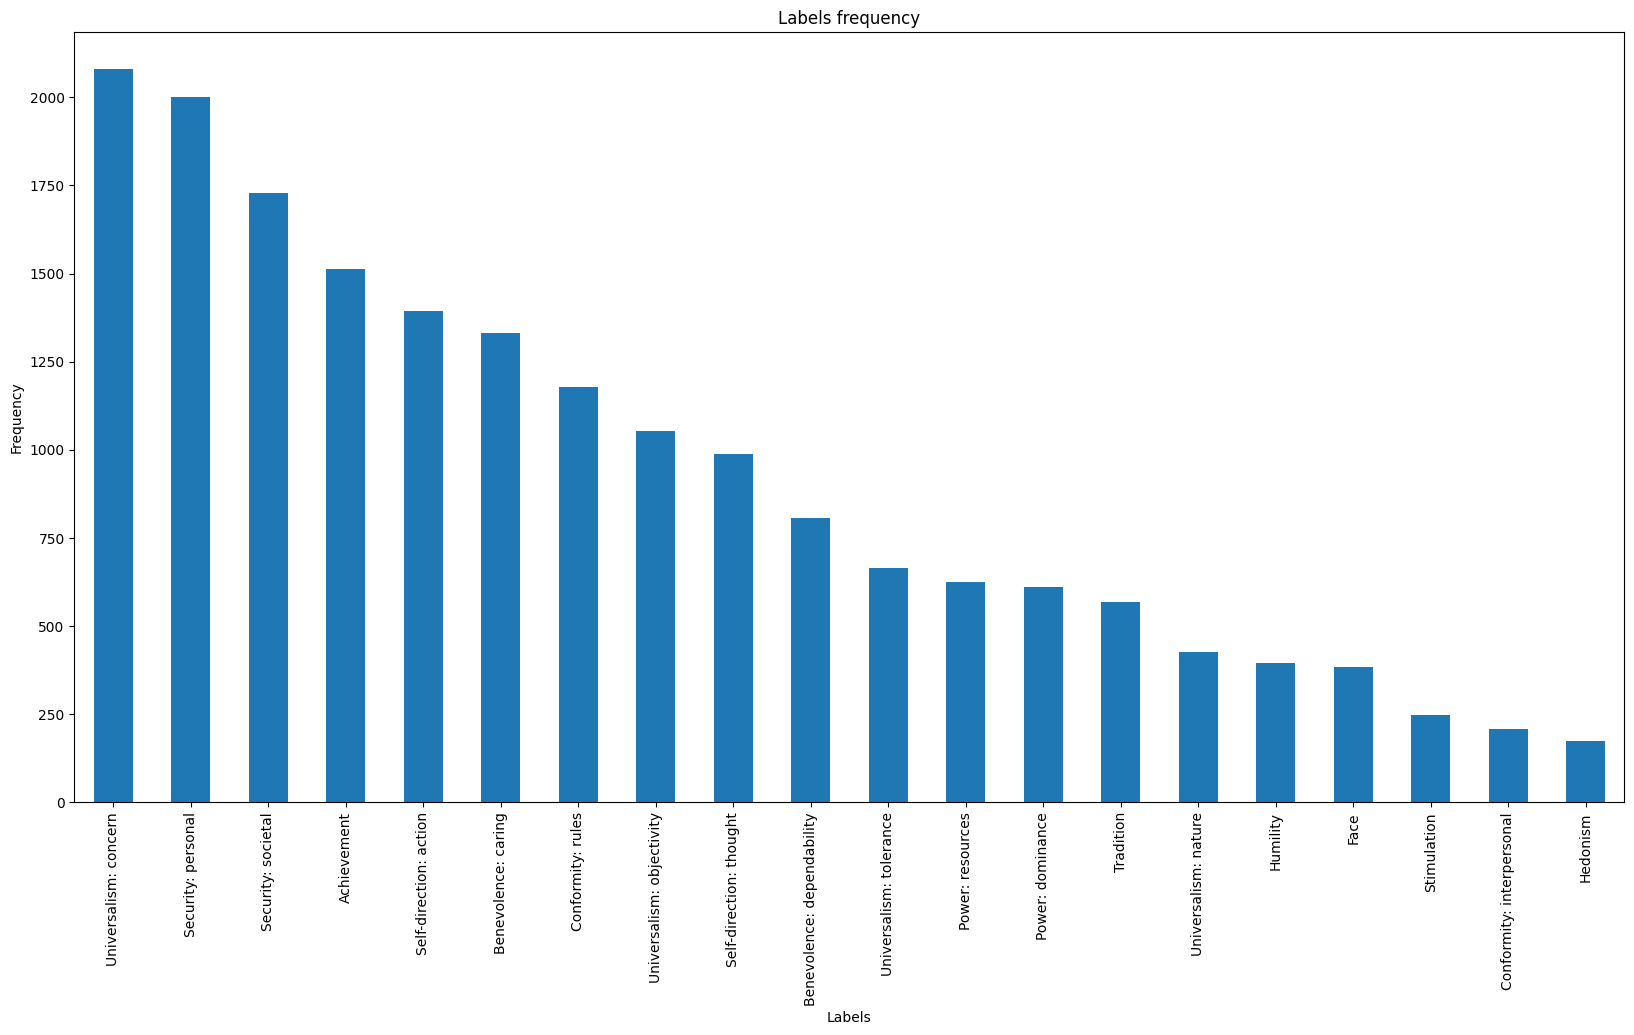

In [ ]:
freq_plot_single(df_training)

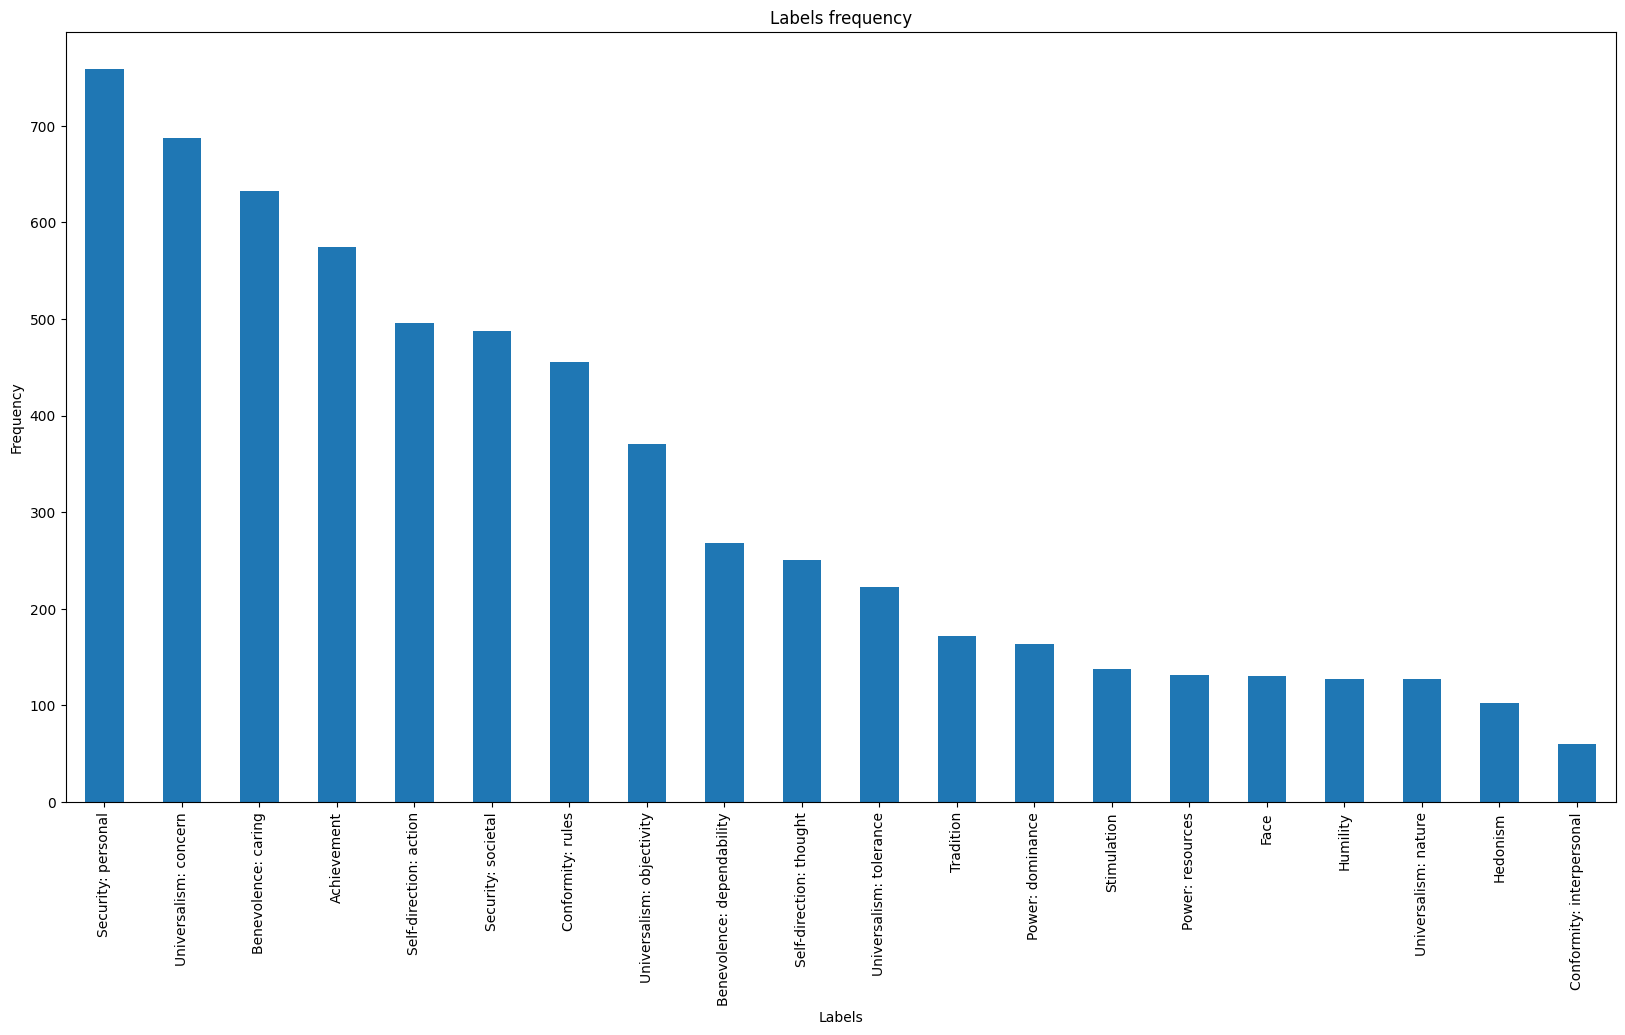

In [ ]:
freq_plot_single(df_validation)

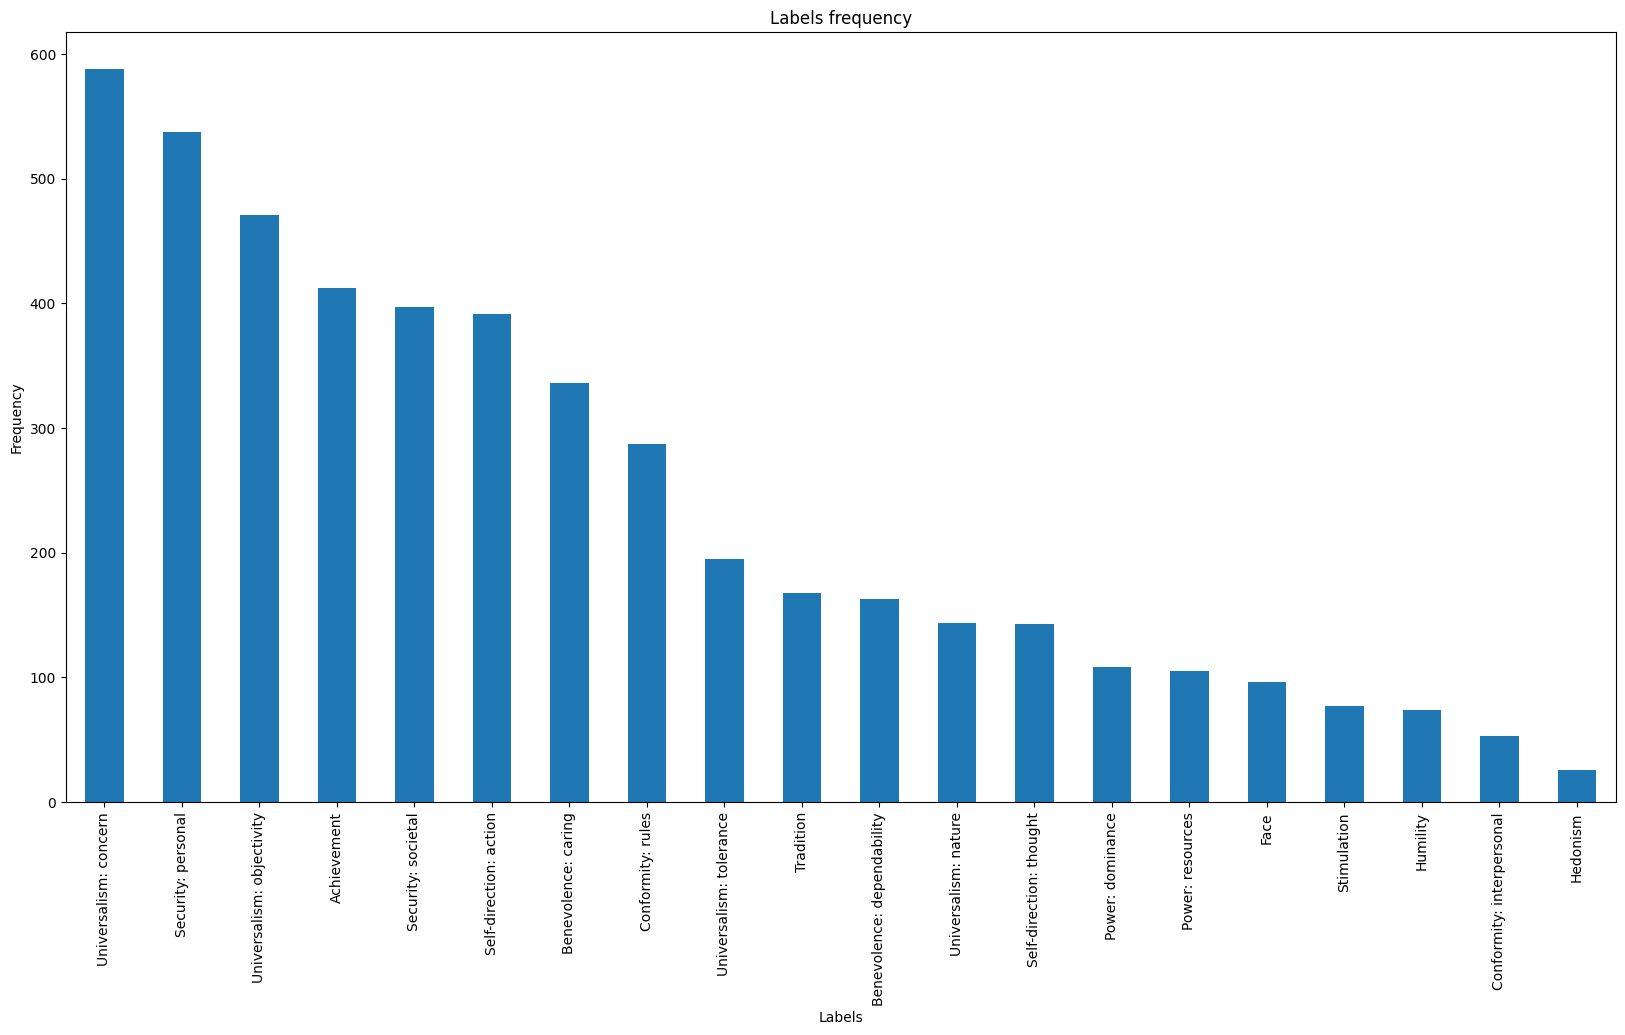

In [ ]:
freq_plot_single(df_test)

In [ ]:
selected_col = ['Conclusion', 'Stance', 'Premise','Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern']

subset_train = df_training[selected_col]
subset_val = df_validation[selected_col]
subset_test = df_test[selected_col]


In [ ]:
# number of labels we are interested in
len(selected_col)-3

6

In [ ]:
def freq_plot(train_df, val_df, test_df):

    train_freq = train_df[train_df.columns[4:]].sum()
    val_freq = val_df[val_df.columns[4:]].sum()
    test_freq = test_df[test_df.columns[4:]].sum()

    fig, ax = plt.subplots(figsize=(20, 10))

    train_freq.plot(kind='bar', ax=ax, color='blue', alpha=0.2, label='Train')
    val_freq.plot(kind='bar', ax=ax, color='yellow', alpha=0.4, label='Validation')
    test_freq.plot(kind='bar', ax=ax, color='red', alpha=0.6, label='Test')

    ax.set_title('Labels frequency')
    ax.set_xlabel('Labels')
    ax.set_ylabel('Frequency')

    ax.legend()
    plt.show()

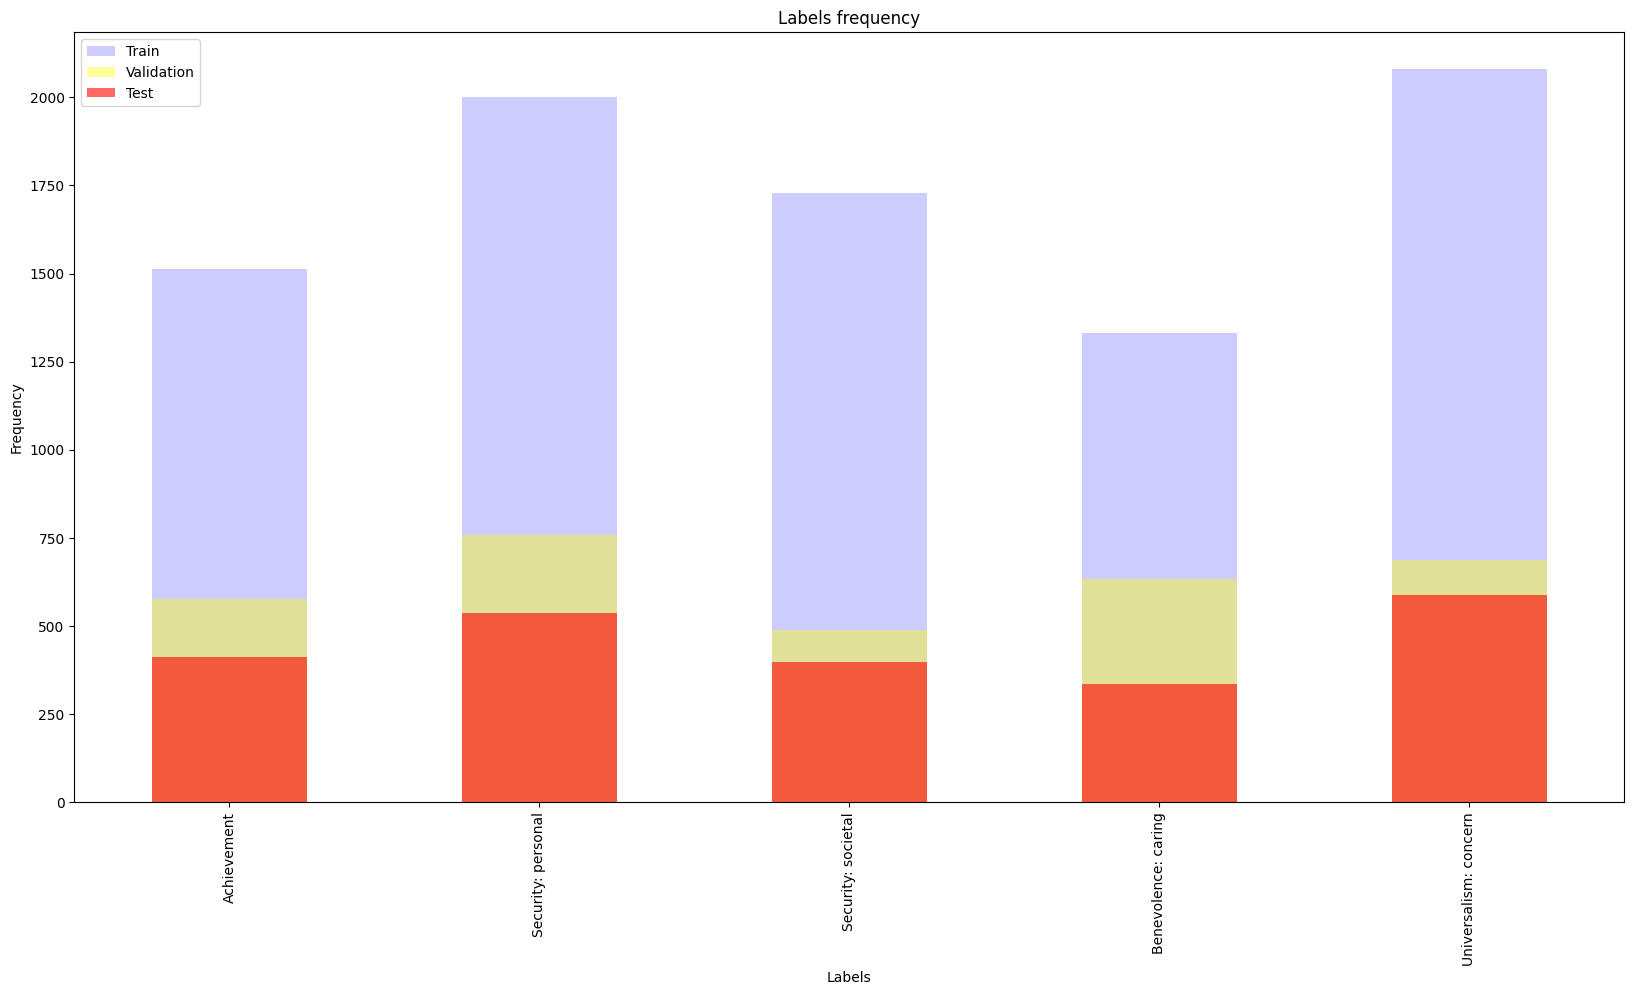

In [ ]:
freq_plot(subset_train, subset_val, subset_test)

co occurence matrix to see which labels are appearing together

each element (i, j) represents the count of data points where both label i and label j are present.

In [ ]:
def freq_co_mat(df):
  matrix = df[df.columns[4:]].T.dot(df[df.columns[4:]])
  fig, ax = plt.subplots(figsize=(20, 10))

  sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", ax=ax)

  ax.set_title('Co-occurrencies')
  ax.set_xlabel('Labels')
  ax.set_ylabel('Labels')

  plt.show()


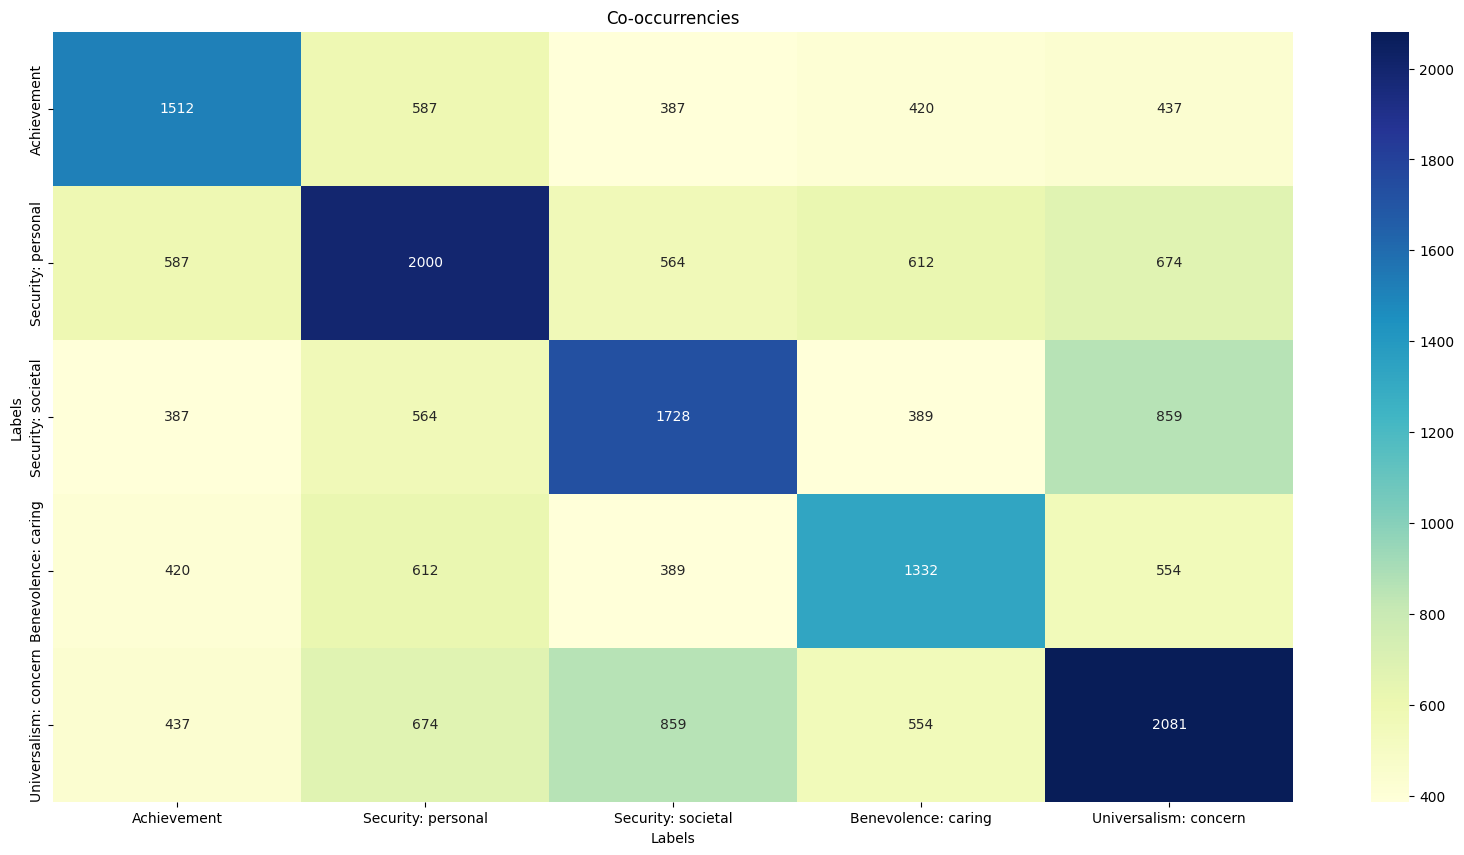

In [ ]:
freq_co_mat(subset_train)

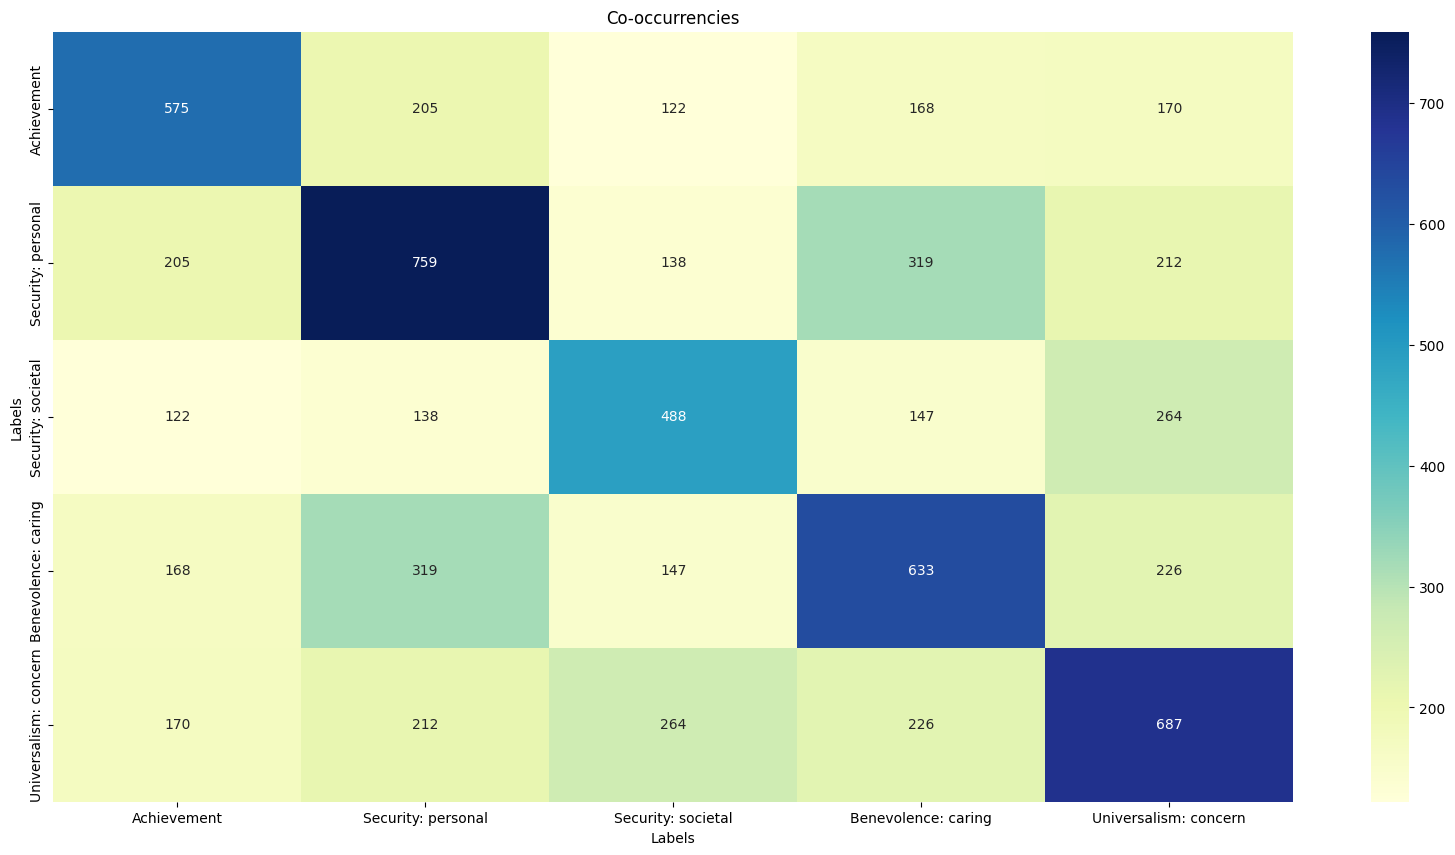

In [ ]:
freq_co_mat(subset_val)

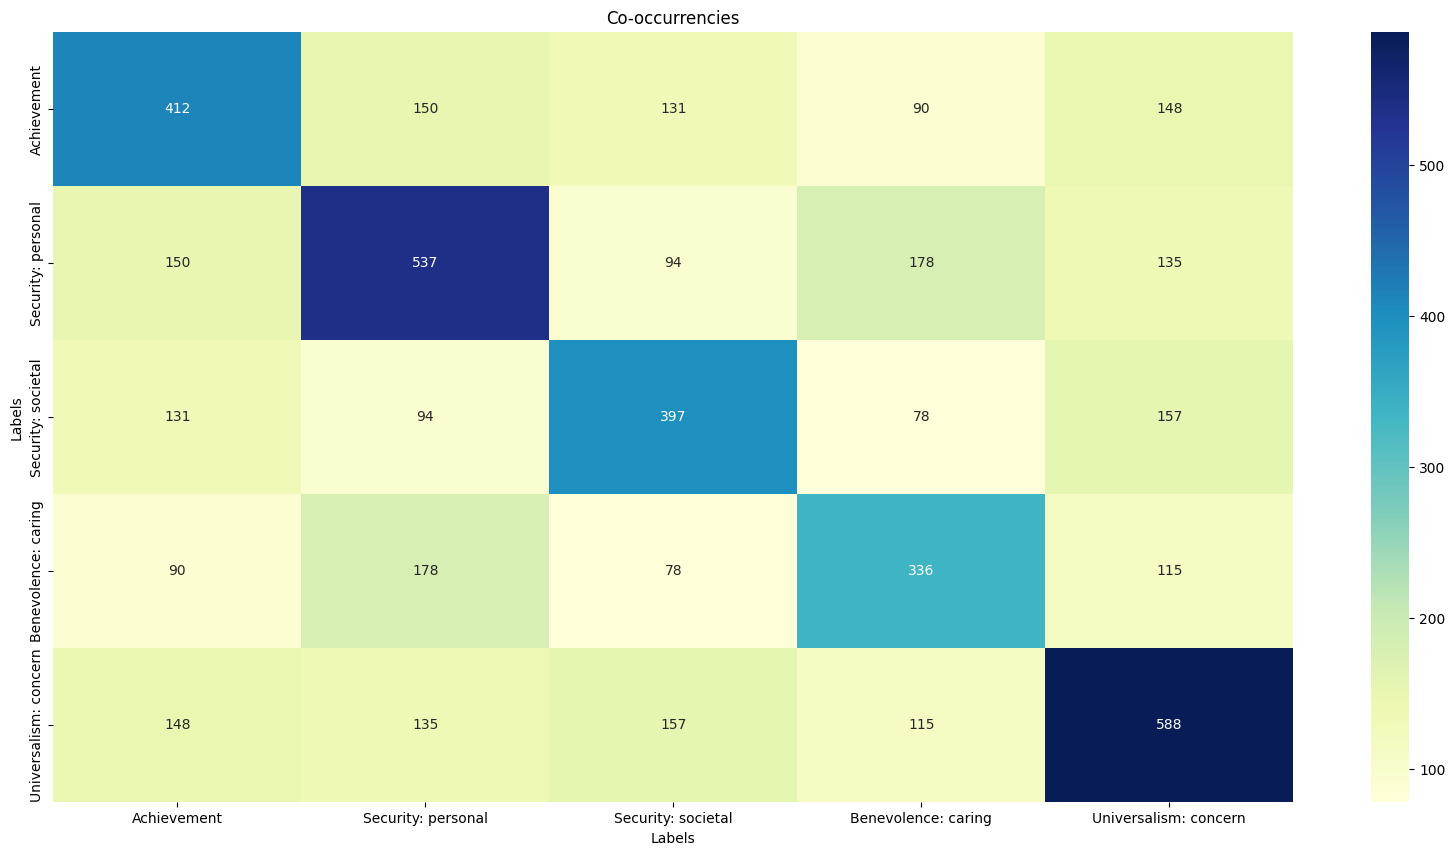

In [ ]:
freq_co_mat(subset_test)

For training purposes, we convert the values of the columns regarding categories in a list of binary values.

In [ ]:
subset_train = subset_train.copy()
subset_train['Text'] = subset_train['Stance'] + " " + subset_train['Conclusion'] + " " + subset_train['Premise']
subset_train.drop(labels=['Conclusion','Premise','Stance'], axis=1, inplace=True)

In [ ]:
subset_train.head(1)

,Self-direction: action,Achievement,Security: personal,Security: societal,Benevolence: caring,Universalism: concern,Text
0,0,0,0,1,0,0,in favor of We should ban human cloning we sho...


In [ ]:
subset_train['list'] = subset_train[subset_train.columns[:6]].values.tolist()
train_set = subset_train[['Text', 'list']].copy()
train_set.head()

,Text,list
0,in favor of We should ban human cloning we sho...,"[0, 0, 0, 1, 0, 0]"
1,in favor of We should ban fast food fast food ...,"[0, 0, 1, 0, 0, 0]"
2,against We should end the use of economic sanc...,"[0, 0, 0, 1, 0, 0]"
3,against We should abolish capital punishment c...,"[0, 0, 0, 1, 0, 1]"
4,against We should ban factory farming factory ...,"[0, 0, 1, 0, 1, 1]"


In [ ]:
subset_test = subset_test.copy()
subset_test['Text'] = subset_test['Stance'] + " " + subset_test['Conclusion'] + " " + subset_test['Premise']
subset_test.drop(labels=['Conclusion','Premise','Stance'], axis=1, inplace=True)

In [ ]:
subset_test.head(1)

,Self-direction: action,Achievement,Security: personal,Security: societal,Benevolence: caring,Universalism: concern,Text
0,0,1,1,0,0,1,against We should end affirmative action affir...


In [ ]:
subset_test['list'] = subset_test[subset_test.columns[:6]].values.tolist()
test_set = subset_test[['Text', 'list']].copy()
test_set.head()

,Text,list
0,against We should end affirmative action affir...,"[0, 1, 1, 0, 0, 1]"
1,in favor of We should end affirmative action a...,"[0, 1, 0, 0, 0, 1]"
2,in favor of We should ban naturopathy naturopa...,"[0, 1, 1, 0, 0, 1]"
3,in favor of We should prohibit women in combat...,"[0, 1, 0, 0, 0, 0]"
4,in favor of We should ban naturopathy once era...,"[0, 1, 1, 1, 1, 0]"


In [ ]:
# try DISTILBERT
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

In [ ]:
def max_text_length(df):
  df['length'] = df['Text'].apply(lambda x: len(tokenizer.encode(x)))
  max_length = df['length'].max()
  return max_length

In [ ]:
MAX_LEN = max(max_text_length(train_set), max_text_length(test_set))
MAX_LEN

189

In [ ]:
# variables that will be used later on in the training
TRAIN_BATCH_SIZE = 32 #aumentare a 32 (eventualmente vedere 64)
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 2e-05

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Text = dataframe.Text
        self.targets = self.data.list
        self.max_len = max_len

    def __len__(self):
        return len(self.Text)

    def __getitem__(self, index):
        Text = str(self.Text[index])
        Text = " ".join(Text.split())

        inputs = self.tokenizer.encode_plus(
            Text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            #pad_to_max_length=True, deprecated
            padding='max_length',
            #return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        #token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            #'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)
print("TRAIN Dataset: {}".format(train_set.shape))
print("TEST Dataset: {}".format(test_set.shape))

TRAIN Dataset: (5393, 3)
TEST Dataset: (1576, 3)


In [ ]:
training_set = CustomDataset(train_set, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_set, tokenizer, MAX_LEN)


In [ ]:

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
import torch
import transformers

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 6)

    def forward(self, ids, mask):
        outputs = self.l1(ids, attention_mask=mask)
        output_1 = outputs.last_hidden_state[:, 0, :]  # DistilBERT doesn't have pooler_output; use the [CLS] token

        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = DistilBERTClass()
model.to(device)


DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)

In [ ]:
def train(epoch):
    model.train()

    losses = []

    t_fin_targets=[]
    t_fin_outputs=[]

    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask) #, token_type_ids)

        t_fin_targets.extend(targets.cpu().detach().numpy().tolist())
        # apply SIGMOID to get multilabel predictions
        t_fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

        #optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        #if _%2000==0:
         #   print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        # backward
        optimizer.zero_grad()
        loss.backward()
        # clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    return t_fin_outputs, t_fin_targets, np.mean(losses)

In [ ]:
def validation(epoch):
    model.eval()

    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad(): #disable gradient calculation, useful for evaluation
        for _, data in enumerate(testing_loader, 0):

            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask) #, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
metrics_train_eval = {}

In [ ]:
for epoch in range(EPOCHS):

    print(f'Epoch: {epoch}')

    # training ----------------------------------------------------------------
    train_outputs, train_targets, train_loss = train(epoch)
    # put to 1 predictions with value >= 0.5
    train_outputs = np.array(train_outputs) >= 0.5

    train_accuracy = metrics.accuracy_score(train_targets, train_outputs)
    train_f1_score_micro = metrics.f1_score(train_targets, train_outputs, average='micro')
    train_f1_score_macro = metrics.f1_score(train_targets, train_outputs, average='macro')
    train_hamming_loss = metrics.hamming_loss(train_targets, train_outputs)

    metrics_train_eval[epoch] = {'Train Accuracy Score' : train_accuracy,
                        'Train F1 Score (Micro)' : train_f1_score_micro,
                        'Train F1 Score (Macro)' : train_f1_score_macro,
                        'Train Hamming Loss' : train_hamming_loss}

    print(f"Train Accuracy Score = {train_accuracy}")
    print(f"Train F1 Score (Micro) = {train_f1_score_micro}")
    print(f"Train F1 Score (Macro) = {train_f1_score_macro}")
    print(f"Train Hamming Loss = {train_hamming_loss}")
    print(f"Train Loss = {train_loss}")


    # validation --------------------------------------------------------------

    eval_outputs, eval_targets = validation(epoch)
    # put to 1 predictions with value >= 0.5
    eval_outputs = np.array(eval_outputs) >= 0.5

    eval_accuracy = metrics.accuracy_score(eval_targets, eval_outputs)
    eval_f1_score_micro = metrics.f1_score(eval_targets, eval_outputs, average='micro')
    eval_f1_score_macro = metrics.f1_score(eval_targets, eval_outputs, average='macro')
    eval_hamming_loss = metrics.hamming_loss(eval_targets, eval_outputs)

    metrics_train_eval[epoch].update({
        'Eval Accuracy Score': eval_accuracy,
        'Eval F1 Score (Micro)': eval_f1_score_micro,
        'Eval F1 Score (Macro)': eval_f1_score_macro,
        'Eval Hamming Loss' : eval_hamming_loss
    })

    print(f"Eval Accuracy Score = {eval_accuracy}")
    print(f"Eval F1 Score (Micro) = {eval_f1_score_micro}")
    print(f"Eval F1 Score (Macro) = {eval_f1_score_macro}")
    print(f"Eval Hamming Loss = {eval_hamming_loss}")

    print('-------------------------------------------------------------------')

Epoch: 0
Train Accuracy Score = 0.1598368255145559
Train F1 Score (Micro) = 0.40002785709311234
Train F1 Score (Macro) = 0.35893195675605877
Train Hamming Loss = 0.26624018789789233
Train Loss = 0.546194955794769
Eval Accuracy Score = 0.23413705583756345
Eval F1 Score (Micro) = 0.5237449118046132
Eval F1 Score (Macro) = 0.46151393449054584
Eval Hamming Loss = 0.22271573604060912
-------------------------------------------------------------------
Epoch: 1
Train Accuracy Score = 0.2662710921564992
Train F1 Score (Micro) = 0.6066289974951942
Train F1 Score (Macro) = 0.5654825649423149
Train Hamming Loss = 0.20869645837196366
Train Loss = 0.45703577289919883
Eval Accuracy Score = 0.2506345177664975
Eval F1 Score (Micro) = 0.6068376068376068
Eval F1 Score (Macro) = 0.5740723134207384
Eval Hamming Loss = 0.2140439932318105
-------------------------------------------------------------------
Epoch: 2
Train Accuracy Score = 0.33283886519562395
Train F1 Score (Micro) = 0.6783704704028809
Train F

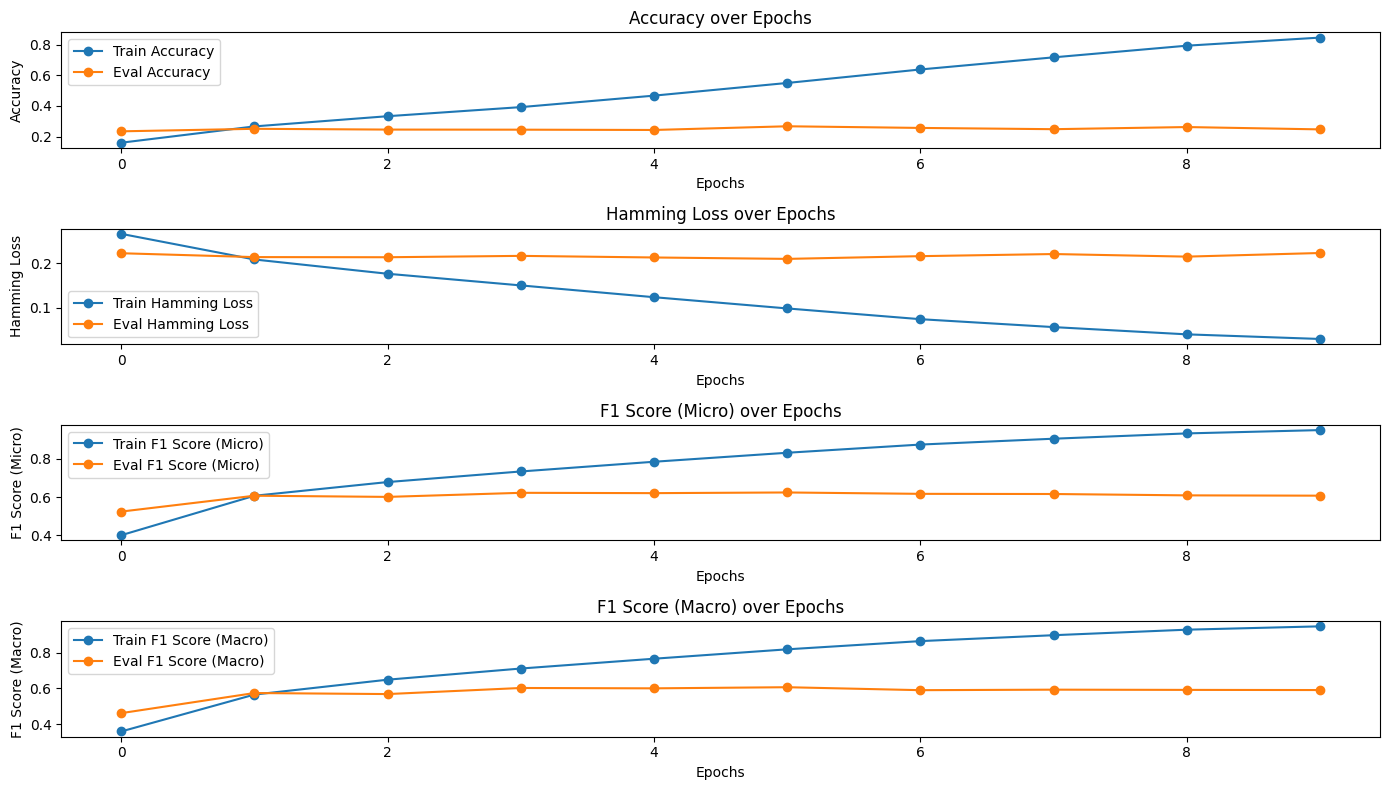

In [ ]:
# extract metrics
epochs = list(metrics_train_eval.keys())

train_accuracy = [metrics_train_eval[epoch]['Train Accuracy Score'] for epoch in epochs]
eval_accuracy = [metrics_train_eval[epoch]['Eval Accuracy Score'] for epoch in epochs]

train_f1_micro = [metrics_train_eval[epoch]['Train F1 Score (Micro)'] for epoch in epochs]
eval_f1_micro = [metrics_train_eval[epoch]['Eval F1 Score (Micro)'] for epoch in
epochs]

train_f1_macro = [metrics_train_eval[epoch]['Train F1 Score (Macro)'] for epoch in epochs]
eval_f1_macro = [metrics_train_eval[epoch]['Eval F1 Score (Macro)'] for epoch in epochs]

train_h_loss = [metrics_train_eval[epoch]['Train Hamming Loss'] for epoch in epochs]
eval_h_loss = [metrics_train_eval[epoch]['Eval Hamming Loss'] for epoch in epochs]

# plot fig
plt.figure(figsize=(14, 8))

# accuracy plot
plt.subplot(4, 1, 1)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, eval_accuracy, label='Eval Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# hamming loss plot
plt.subplot(4, 1, 2)
plt.plot(epochs, train_h_loss, label='Train Hamming Loss', marker='o')
plt.plot(epochs, eval_h_loss, label='Eval Hamming Loss', marker='o')
plt.title('Hamming Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Hamming Loss')
plt.legend()

# F1 micro plot
plt.subplot(4, 1, 3)
plt.plot(epochs, train_f1_micro, label='Train F1 Score (Micro)', marker='o')
plt.plot(epochs, eval_f1_micro, label='Eval F1 Score (Micro)', marker='o')
plt.title('F1 Score (Micro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Micro)')
plt.legend()

# F1 macro plot
plt.subplot(4, 1, 4)
plt.plot(epochs, train_f1_macro, label='Train F1 Score (Macro)', marker='o')
plt.plot(epochs, eval_f1_macro, label='Eval F1 Score (Macro)', marker='o')
plt.title('F1 Score (Macro) over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score (Macro)')
plt.legend()

plt.tight_layout()
plt.show()

deeper look at model's outputs for single example
labels: 'Self-direction: action', 'Achievement', 'Security: personal', 'Security: societal', 'Benevolence: caring', 'Universalism: concern'

In [ ]:
test_set.head(1)

,Text,list,length
0,against We should end affirmative action affir...,"[0, 1, 1, 0, 0, 1]",15


In [ ]:
test_item_0 = testing_set.__getitem__(0)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
#token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0)) #, token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-6.2288,  2.9346, -0.7381, -5.7054, -2.9127,  0.4598]],
       device='cuda:0')
Model Output after SIGMOID: [[0.001967919757589698, 0.9495284557342529, 0.32341670989990234, 0.0033169265370815992, 0.051527224481105804, 0.6129575371742249]]
Model Output threshold: [[False  True False False False  True]]
Actual Target: tensor([0., 1., 1., 0., 0., 1.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))
print("Hamming loss:", metrics.hamming_loss(targets_flat, outputs_flat))

Accuracy Score: 0.8333333333333334
F1 micro Score: 0.8333333333333334
F1 macro Score: 0.8285714285714285
Hamming loss: 0.16666666666666666


In [ ]:
test_set[87:88]

,Text,list,length
87,in favor of We should abandon marriage marriag...,"[0, 0, 1, 0, 0, 1]",37


In [ ]:
test_item_0 = testing_set.__getitem__(87)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
#token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0)) #, token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-7.0675,  2.4800, -0.3003, -3.6696, -2.8994,  0.5557]],
       device='cuda:0')
Model Output after SIGMOID: [[0.0008516511297784746, 0.9227244853973389, 0.4254833161830902, 0.02485276199877262, 0.052184686064720154, 0.6354566216468811]]
Model Output threshold: [[False  True False False False  True]]
Actual Target: tensor([0., 0., 1., 0., 0., 1.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))
print("Hamming loss:", metrics.hamming_loss(targets_flat, outputs_flat))

Accuracy Score: 0.6666666666666666
F1 micro Score: 0.6666666666666666
F1 macro Score: 0.625
Hamming loss: 0.3333333333333333


In [ ]:
test_set[1456:1457]

,Text,list,length
1456,"against We should get migration from Asia, and...","[0, 0, 0, 0, 0, 0]",31


In [ ]:
test_item_0 = testing_set.__getitem__(1456)
ids = test_item_0['ids'].to(device, dtype = torch.long)
mask = test_item_0['mask'].to(device, dtype = torch.long)
#token_type_ids = test_item_0['token_type_ids'].to(device, dtype = torch.long)
targets = test_item_0['targets'] #

# disable gradient calculation, add an extra dimension to the input tensors using unsqueeze(0) to create a batch of size 1.
with torch.no_grad():
    outputs = model(ids.unsqueeze(0), mask.unsqueeze(0)) #, token_type_ids.unsqueeze(0))

print("Model Output:", outputs)

outputs = torch.sigmoid(outputs).cpu().detach().numpy().tolist()
print("Model Output after SIGMOID:", outputs)

outputs = np.array(outputs) >= 0.5

# model's output and the actual target
print("Model Output threshold:", outputs)
print("Actual Target:", targets)

Model Output: tensor([[-5.6145,  1.8128,  0.9479, -1.2427, -3.9495, -5.2562]],
       device='cuda:0')
Model Output after SIGMOID: [[0.003631328698247671, 0.8597015142440796, 0.7206944823265076, 0.22396790981292725, 0.018900251016020775, 0.005188122857362032]]
Model Output threshold: [[False  True  True False False False]]
Actual Target: tensor([0., 0., 0., 0., 0., 0.])


In [ ]:
# flat the outputs and targets arrays
outputs_flat = np.ravel(outputs)
targets_flat = np.ravel(targets)

print("Accuracy Score:", metrics.accuracy_score(targets_flat, outputs_flat))
print("F1 micro Score:", metrics.f1_score(targets_flat, outputs_flat, average='micro'))
print("F1 macro Score:", metrics.f1_score(targets_flat, outputs_flat, average='macro'))
print("Hamming loss:", metrics.hamming_loss(targets_flat, outputs_flat))

Accuracy Score: 0.6666666666666666
F1 micro Score: 0.6666666666666666
F1 macro Score: 0.4
Hamming loss: 0.3333333333333333


look at accuracy per single label (for binary classification acc is equal to f1 micro)

In [ ]:
n_labels = 6
value_col = selected_col[3:]
acc = dict()

In [ ]:
e_t = np.array(eval_targets)
e_p = np.array(eval_outputs)

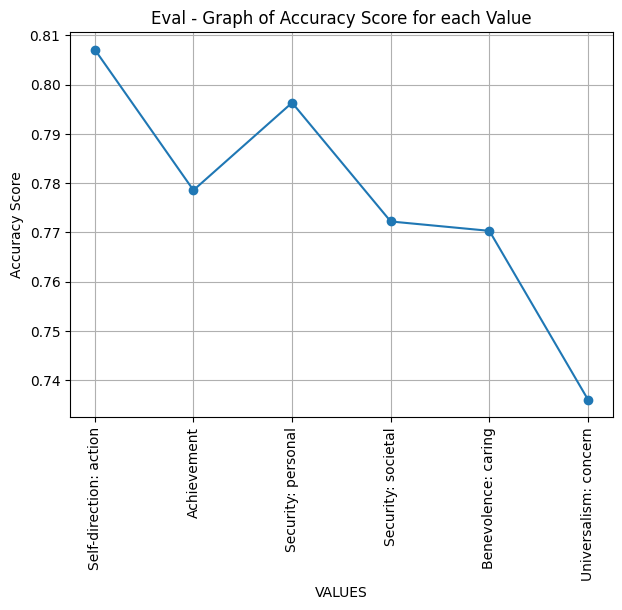

In [ ]:
for i in range(n_labels):
  acc[value_col[i]] = metrics.accuracy_score(e_t[:, i], e_p[:, i])

plt.figure(figsize=(7, 5))

plt.plot(list(acc.keys()), list(acc.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('Accuracy Score')
plt.title('Eval - Graph of Accuracy Score for each Value')

plt.grid(True)
plt.show()

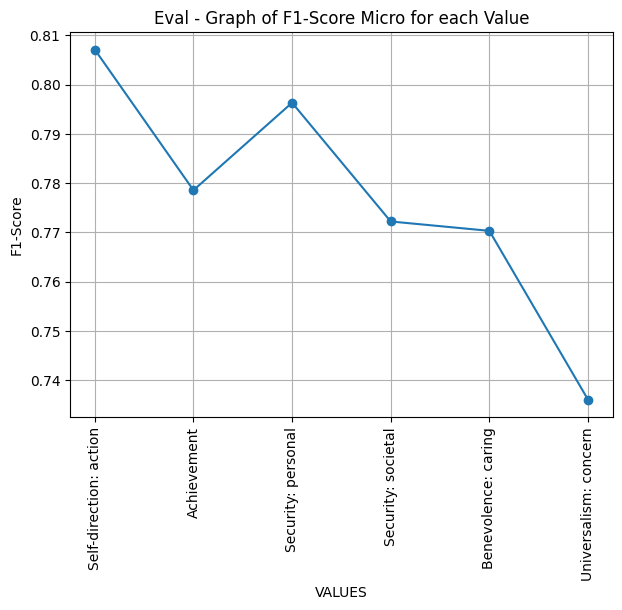

In [ ]:
f1 = dict()
for i in range(n_labels):
  f1[value_col[i]] = metrics.f1_score(e_t[:, i], e_p[:, i], average='micro')

plt.figure(figsize=(7, 5))

plt.plot(list(f1.keys()), list(f1.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('F1-Score')
plt.title('Eval - Graph of F1-Score Micro for each Value')

plt.grid(True)
plt.show()

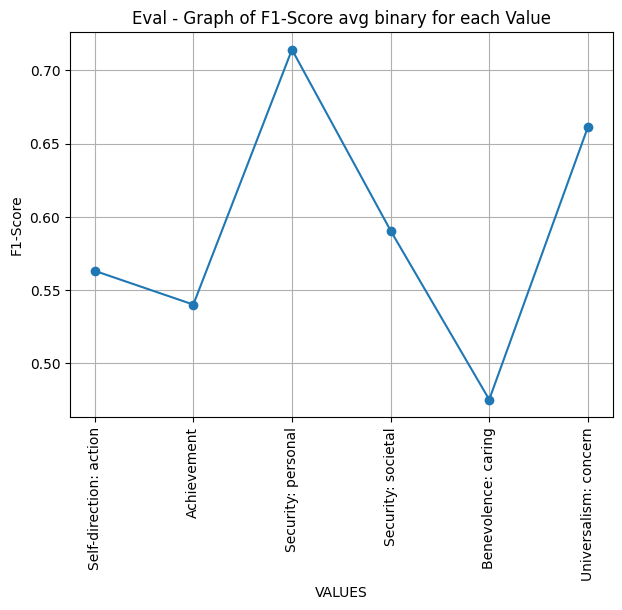

In [ ]:
f1 = dict()
for i in range(n_labels):
  f1[value_col[i]] = metrics.f1_score(e_t[:, i], e_p[:, i], average='binary')

plt.figure(figsize=(7, 5))

plt.plot(list(f1.keys()), list(f1.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('F1-Score')
plt.title('Eval - Graph of F1-Score avg binary for each Value')

plt.grid(True)
plt.show()

comparison with train

In [ ]:
acc_t = dict()

In [ ]:
e_t_t = np.array(train_targets)
e_p_t = np.array(train_outputs)

In [ ]:
for i in range(n_labels):
  acc_t[value_col[i]] = metrics.accuracy_score(e_t_t[:, i], e_p_t[:, i])

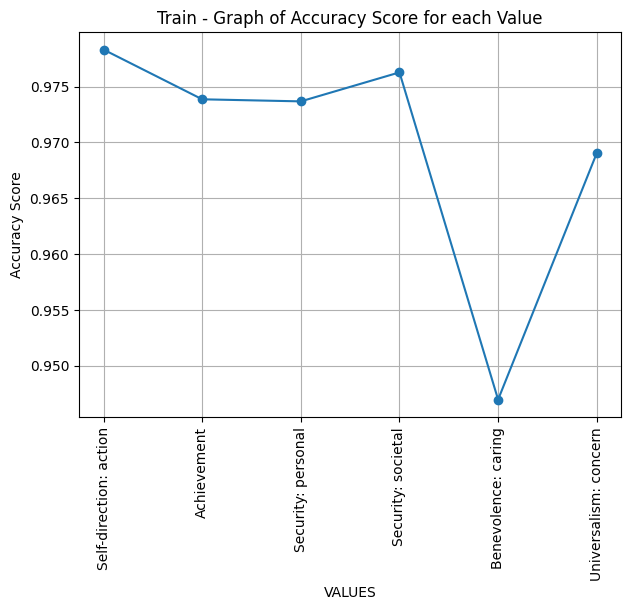

In [ ]:
plt.figure(figsize=(7, 5))

plt.plot(list(acc_t.keys()), list(acc_t.values()), marker='o')

plt.xlabel('VALUES')
plt.xticks(rotation='vertical')

plt.ylabel('Accuracy Score')
plt.title('Train - Graph of Accuracy Score for each Value')

plt.grid(True)
plt.show()